This files contains an example of tuning a Random Forest model with BayesSearchCV.

In [1]:
import pickle
import time

import helpsk as hlp
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import plotly.io as pio
pio.renderers.default='notebook'

# Load Data

In [2]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)

In [3]:
hlp.pandas.numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,760,40,5.0%,0,0.0%,21.0,11.7,0.6,1.0,0.6,4.0,9.0,12.0,18.0,24.0,36.0,60.0
credit_amount,800,0,0.0%,38,5.0%,"3,203.9","2,932.3",0.9,1.9,3.9,0.0,753.9,"1,300.8","2,236.5","3,951.5","7,394.6","18,424.0"
installment_commitment,800,0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,800,0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,800,0,0.0%,0,0.0%,35.6,11.4,0.3,1.0,0.7,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,800,0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,800,0,0.0%,0,0.0%,1.1,0.3,0.3,2.0,2.1,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [4]:
hlp.pandas.non_numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,763,37,4.6%,no checking,4,0.5%
credit_history,800,0,0.0%,existing paid,5,0.6%
purpose,800,0,0.0%,radio/tv,10,1.2%
savings_status,800,0,0.0%,<100,5,0.6%
employment,800,0,0.0%,1<=X<4,5,0.6%
personal_status,800,0,0.0%,male single,4,0.5%
other_parties,800,0,0.0%,none,3,0.4%
property_magnitude,800,0,0.0%,car,4,0.5%
other_payment_plans,800,0,0.0%,none,3,0.4%
housing,800,0,0.0%,own,3,0.4%


In [5]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [6]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [7]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

# Transformation Pipeline

In [8]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [9]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [10]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('imputer', hlp.sklearn_pipeline.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaler', hlp.sklearn_pipeline.TransformerChooser()),
])

In [11]:
non_numeric_pipeline = Pipeline([
    ('encoder', hlp.sklearn_pipeline.TransformerChooser()),
])

In [12]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('non_numeric', non_numeric_pipeline, non_numeric_columns)
])

# Model

`XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded on Apple Silicon (ARM)`

https://github.com/dmlc/xgboost/issues/6909

```
pip install --upgrade --force-reinstall xgboost --no-binary xgboost -v
```

In [23]:
from xgboost import XGBClassifier
#from sklearn.decomposition import KernelPCA

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)

In [24]:
full_pipeline = Pipeline([
    ('prep', transformations_pipeline),
#     ('pca', KernelPCA()),
#     ('pca', hlp.sklearn_pipeline.TransformerChooser()),
    ('model', xgb_model)
])

In [25]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer',
                                                   TransformerChooser()),
                                                  ('scaler',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric',
                                  Pipeline(steps=[('encoder',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                                   'personal_status', 'other_parties',
     

# skopt.BayesSearchCV

[https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html)

In [26]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score  # , roc_auc_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [27]:
num_folds = 5
num_repeats = 2

In [28]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedKFold

https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

> max_depth: 3–10
> n_estimators: 100 (lots of observations) to 1000 (few observations)
> learning_rate: 0.01–0.3
> colsample_bytree: 0.5–1
> subsample: 0.6–1

> Then, you can focus on optimizing max_depth and n_estimators.
You can then play along with the learning_rate, and increase it to speed up the model without decreasing the performances. If it becomes faster without losing in performances, you can increase the number of estimators to try to increase the performances.

In [212]:
search_space = {
    'prep__numeric__imputer__transformer': Categorical([SimpleImputer(strategy='mean')]),
    'prep__numeric__scaler__transformer': Categorical([
        None,
        MinMaxScaler(),
        StandardScaler()
    ]),
    'prep__non_numeric__encoder__transformer': Categorical([
#        None,
        OneHotEncoder(),
        hlp.sklearn_pipeline.CustomOrdinalEncoder()
    ]),
#     'pca__transformer': Categorical([
#         None,
#         KernelPCA(n_components=5, kernel='rbf'),
#         KernelPCA(n_components=5, kernel='sigmoid'),
#         KernelPCA(n_components=5, kernel='linear'),
#     ]),
#     'pca__n_components': Integer(3, X_train.shape[1]),
#     'pca__gamma': Real(0.03, 0.05),
#     'pca__kernel': Categorical(['rbf', 'sigmoid']),
    'model__max_depth': Integer(3, 10),
    'model__n_estimators':  Integer(50, 2000),
    'model__learning_rate': Real(0.01, 0.3),
    'model__colsample_bytree': Real(0.01, 1),
    'model__subsample': Real(0.5, 1),
}

bayes_search = BayesSearchCV(
    estimator=full_pipeline,
    search_spaces=search_space,
    n_iter=50,
    cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
    scoring='roc_auc',
    #return_train_score=True,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

start_time = time.time()
bayes_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

del search_space

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [213]:
print(f"Elapsed time to run BayesSearchCV: {elapsed_time:.3f} seconds; {elapsed_time / 60:.1f} minutes")

Elapsed time to run BayesSearchCV: 121.200 seconds; 2.0 minutes


In [214]:
print(bayes_search.cv_results_)

{'mean_fit_time': array([0.82099562, 2.75345426, 0.85999126, 3.28745658, 1.21627727,
       0.6226289 , 1.05438023, 1.73493252, 1.71328628, 0.14795105,
       2.77437186, 0.32081969, 0.09624519, 0.10904353, 0.51194701,
       0.06620264, 0.03856318, 0.07621377, 0.02606566, 0.03681476,
       0.05360446, 0.04648621, 0.5231828 , 1.72768099, 0.294607  ,
       0.76080384, 0.04011278, 0.05018058, 0.13161728, 0.12275882,
       0.04882104, 0.09104567, 0.53017197, 0.13807549, 0.57760315,
       0.09662225, 0.35637822, 0.04081523, 0.95211084, 0.12193835,
       0.21852615, 0.82092929, 1.40817235, 0.2474339 , 0.37018576,
       0.11042922, 0.9911047 , 0.35422697, 0.36130605, 0.36422617]), 'std_fit_time': array([0.10721416, 0.39807828, 0.12899863, 0.45463749, 0.17274964,
       0.09440456, 0.13937099, 0.24121142, 0.24354042, 0.01048061,
       0.38929856, 0.04785467, 0.00659313, 0.01839724, 0.08569621,
       0.01027629, 0.00924488, 0.01077971, 0.00732856, 0.00825626,
       0.0081349 , 0.00921

In [215]:
print(bayes_search.best_score_)

0.7724026539462673


In [216]:
print(bayes_search.best_params_)

OrderedDict([('model__colsample_bytree', 0.26338903833303606), ('model__learning_rate', 0.01), ('model__max_depth', 3), ('model__n_estimators', 171), ('model__subsample', 0.7824316763976555), ('prep__non_numeric__encoder__transformer', CustomOrdinalEncoder()), ('prep__numeric__imputer__transformer', SimpleImputer()), ('prep__numeric__scaler__transformer', StandardScaler())])


# Results

In [217]:
new_param_column_names = {
    'model__max_depth': 'max_depth',
    'model__n_estimators': 'n_estimators',
    'model__learning_rate': 'learning_rate',
    'model__colsample_bytree': 'colsample_bytree',
    'model__subsample': 'subsample',
#     'pca__transformer': 'pca',
#     'pca__n_components': 'pca: n_comps',
#     'pca__gamma': 'pca: gamma',
#     'pca__kernel': 'pca: kernel',
    'prep__non_numeric__encoder__transformer': 'encoder',
    'prep__numeric__imputer__transformer': 'imputer',
    'prep__numeric__scaler__transformer': 'scaler'
}

In [218]:
parser = hlp.sklearn_eval.SearchCVParser(searcher=bayes_search,
                                         higher_score_is_better = True,
                                         parameter_name_mappings = new_param_column_names)

In [219]:
parser.to_yaml_file(yaml_file_name = 'Run 1 - XGBoost - BayesSearchCV.yaml')

In [220]:
parser = hlp.sklearn_eval.SearchCVParser.from_yaml_file(yaml_file_name = 'Run 1 - XGBoost - BayesSearchCV.yaml')

## Timings

In [221]:
parser.fit_time_averages

array([0.82099562, 2.75345426, 0.85999126, 3.28745658, 1.21627727,
       0.6226289 , 1.05438023, 1.73493252, 1.71328628, 0.14795105,
       2.77437186, 0.32081969, 0.09624519, 0.10904353, 0.51194701,
       0.06620264, 0.03856318, 0.07621377, 0.02606566, 0.03681476,
       0.05360446, 0.04648621, 0.5231828 , 1.72768099, 0.294607  ,
       0.76080384, 0.04011278, 0.05018058, 0.13161728, 0.12275882,
       0.04882104, 0.09104567, 0.53017197, 0.13807549, 0.57760315,
       0.09662225, 0.35637822, 0.04081523, 0.95211084, 0.12193835,
       0.21852615, 0.82092929, 1.40817235, 0.2474339 , 0.37018576,
       0.11042922, 0.9911047 , 0.35422697, 0.36130605, 0.36422617])

## Best Scores/Params

In [222]:
parser.best_primary_score

0.7724026539462673

In [223]:
parser.best_primary_score_params

{'colsample_bytree': 0.26338903833303606,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 171,
 'subsample': 0.7824316763976555,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'StandardScaler()'}

In [224]:
parser.to_formatted_dataframe()

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,encoder,scaler
0.772,0.751,0.794,0.263,0.010,3,171,0.782,CustomOrdinalEncoder(),StandardScaler()
0.772,0.751,0.793,0.146,0.010,10,279,0.569,CustomOrdinalEncoder(),StandardScaler()
0.771,0.745,0.798,0.170,0.010,10,226,0.763,CustomOrdinalEncoder(),None
0.770,0.753,0.788,0.010,0.010,3,"1,466",0.680,CustomOrdinalEncoder(),StandardScaler()
0.770,0.740,0.801,0.011,0.025,7,229,0.994,CustomOrdinalEncoder(),StandardScaler()
0.767,0.742,0.792,0.385,0.010,10,236,0.915,CustomOrdinalEncoder(),StandardScaler()
0.767,0.749,0.785,0.199,0.042,3,237,0.500,CustomOrdinalEncoder(),StandardScaler()
0.766,0.745,0.788,0.241,0.031,3,50,0.609,CustomOrdinalEncoder(),StandardScaler()
0.759,0.734,0.785,0.386,0.010,5,50,1.000,CustomOrdinalEncoder(),None
0.759,0.719,0.798,0.010,0.010,3,369,0.539,CustomOrdinalEncoder(),StandardScaler()


In [225]:
# gives the score rank for each index
# e.g. array([4, 2, 1, 3)
# the 1st iteration (i.e. set of params) was the worst
# the 3rd iteration was the best.
parser.primary_score_iteration_ranking

array([31, 47, 40, 36, 35, 37, 43, 44, 45, 41, 32, 30, 34,  5, 16,  9, 19,
       12, 23, 27, 38, 20, 13, 42, 49, 28,  8, 24,  7, 10, 11, 14, 22,  2,
       50,  1,  6, 29, 21, 15, 25, 17, 26,  3, 48, 33, 46,  4, 18, 39])

In [226]:
# gives the 
# e.g. parser.primary_score_iteration_ranking of array([4, 2, 1, 3)
# would return [2, 1, 4, 0] because index 2 (i.e. 3rd iteration) was the best, so it is the first index;
# and index 0 (i.e. first iteration) was the was
parser.primary_score_best_indexes

array([35, 33, 43, 47, 13, 36, 28, 26, 15, 29, 30, 17, 22, 31, 39, 14, 41,
       48, 16, 21, 38, 32, 18, 27, 40, 42, 19, 25, 37, 11,  0, 10, 45, 12,
        4,  3,  5, 20, 49,  2,  9, 23,  6,  7,  8, 46,  1, 44, 24, 34])

In [227]:
score_df = parser.to_dataframe(sort_by_score=False)
columns = score_df.columns.to_list()  # cache columns to move Iteration column to front
score_df['Iteration'] = np.arange(1, parser.number_of_iterations + 1)
score_df = score_df[['Iteration'] + columns]
# create the labels that will be used in the plotly hover text
score_df['labels'] = [x.replace('{', '<br>').replace(', ', '<br>').replace('}', '')
                      for x in parser.iteration_labels(order_from_best_to_worst=False)]
del columns

score_variable = parser.primary_score_name + " Mean"

In [228]:
score_df.head(1)

,Iteration,roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,encoder,imputer,scaler,labels
0,1,0.730432,0.698533,0.76233,0.416003,0.22104,10,666,0.835074,OneHotEncoder(),SimpleImputer(),MinMaxScaler(),<br>colsample_bytree: 0.4160029192647807<br>le...


## BayesSearchCV Performance Over Time

In [229]:
size_variable = 'learning_rate'
color_variable = 'colsample_bytree'
fig = px.scatter(
    data_frame=score_df,
    x='Iteration',
    y=score_variable,
    size=size_variable,
    color=color_variable,
    trendline='lowess',
    labels={
        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
    },
    title=f"Bayesian Performance Over Time<br>" \
          f"<sup>Size of point corresponds to '{size_variable}'</sup>",
    custom_data=['labels'],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Iteration: %{x}",
        score_variable + ": " + "%{y}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.show()

del size_variable
del color_variable

---

## Variable Performance Over Time

In [230]:
score_df_long_numeric = pd.melt(score_df,
                                id_vars=['Iteration', score_variable, 'labels'],
                                value_vars=parser.numeric_parameters)
#score_df_long_numeric.head(1)

In [231]:
color_variable = score_variable
fig = px.scatter(
    data_frame=score_df_long_numeric,
    x='Iteration',
    y='value',
    color=color_variable,
    facet_col='variable',
    trendline='lowess',
    labels={
        'value': 'Parameter Value',
    },
    title="Variable Performance Over Time",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Iteration: %{x}",
        "Parameter Value: %{y}",
        "roc_auc Mean: %{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

del color_variable

---

## Variable Performance - Numeric

In [232]:
color_variable = score_variable
fig = px.scatter(
    data_frame=score_df_long_numeric,
    x='value',
    y=score_variable,
    color=color_variable,
    facet_col='variable',
    facet_col_wrap=2,
    trendline='lowess',
    labels={
#        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
        'value': 'Parameter Value',
    },
    title="Variable Performance<br><sup>Numeric Parameters</sup>",
    custom_data=['labels', score_variable],
    height=1000,
    width=1000*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Parameter Value: %{x}",
        "roc_auc Mean: %{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.update_xaxes(matches=None, showticklabels=True)
#fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

del color_variable

---

## Variable Performance - Non-Numeric

In [233]:
score_df_long_non_numeric = pd.melt(score_df,
                                    id_vars=['Iteration', score_variable, 'labels'],
                                    value_vars=parser.non_numeric_parameters)
#score_df_long_numeric.head(1)

In [234]:
color_variable = score_variable
scatter = px.scatter(
    data_frame=score_df_long_non_numeric,
    x='value',
    y=score_variable,
    color=color_variable,
    facet_col='variable',
    facet_col_wrap=2,
    #trendline='lowess',
    labels={
#        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
        'value': 'Parameter Value',
    },
    title="Variable Performance<br><sup>Non-Numeric Parameters</sup>",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
scatter.update_traces(
    hovertemplate="<br>".join([
        "Parameter Value: %{x}",
        "roc_auc Mean: %{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
scatter.update_xaxes(matches=None, showticklabels=True)
#scatter.show()

del color_variable

In [235]:
color_variable = score_variable
fig = px.box(
    data_frame=score_df_long_non_numeric,
    x='value',
    y=score_variable,
#    color=color_variable,
    facet_col='variable',
    facet_col_wrap=2,
    #trendline='lowess',
    labels={
#        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
        'value': 'Parameter Value',
    },
    title="Variable Performance<br><sup>Non-Numeric Parameters</sup>",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
for x in range(len(scatter.data)):
    fig.add_trace(scatter.data[x])

fig.update_xaxes(matches=None, showticklabels=True)
fig.show()

del color_variable

## Individual Variable Performance

---

In [236]:
x_variable = 'learning_rate'
size_variable = 'colsample_bytree'
#color_variable = 'scaler'
fig = px.scatter(
    data_frame=score_df,
    x=x_variable,
    y=score_variable,
    size=size_variable,
#    color=color_variable,
    trendline='lowess',
    labels={
        score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
    },
    title=f"<b>{x_variable}</b> - Performance<br>" \
          f"<sup>Size of point corresponds to '{size_variable}'</sup>",
    custom_data=['labels'],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Parameter Value: %{x}",
        score_variable + ": " + "%{y}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.show()

del x_variable
del size_variable
#del color_variable

In [237]:
size_variable = score_variable

from sklearn.preprocessing import MinMaxScaler
scaled_size = MinMaxScaler().fit_transform(score_df[[size_variable]]).reshape(1, -1)
scaled_size = scaled_size.tolist()[0]

x_variable = 'learning_rate'
y_variable = 'colsample_bytree'

color_variable = score_variable
fig = px.scatter(
    data_frame=score_df,
    x=x_variable,
    y=y_variable,
#    size=score_df[size_variable],
    size=scaled_size,
    color=color_variable,
    trendline='lowess',
#     labels={
#         score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
#     },
    title=f"Performance of <b>{x_variable}</b> vs <b>{y_variable}</b><br>" \
          f"<sup>color and size corresponds to `{score_variable}`</sup>",
    custom_data=['labels', score_variable],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.update_traces(
    hovertemplate="<br>".join([
        x_variable + ": %{x}",
        y_variable + ": %{y}",
        score_variable + ": " + "%{customdata[1]}",
        "<br>Parameters: %{customdata[0]}",
    ])
)
fig.show()

del x_variable
del size_variable
del scaled_size
del color_variable

---

# Regression on `roc_auc Mean`

In [238]:
score_variable

'roc_auc Mean'

In [239]:
score_dataframe = parser.to_dataframe()
score_dataframe = score_dataframe.drop(columns=[x for x in score_dataframe.columns
                              if x not in [score_variable] + parser.parameter_names])
score_dataframe.head()

,roc_auc Mean,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,encoder,imputer,scaler
35,0.772403,0.263389,0.010000,3,171,0.782432,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
33,0.772154,0.145812,0.010000,10,279,0.569162,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
43,0.771322,0.170401,0.010000,10,226,0.763149,CustomOrdinalEncoder(),SimpleImputer(),None
47,0.770422,0.010000,0.010000,3,1466,0.680311,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
13,0.770286,0.011458,0.024867,7,229,0.993715,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [240]:
cleaned_column_names = [''.join(e for e in x.replace(' ', '_') if e == '_' or e.isalnum()) for x in score_dataframe.columns.tolist()]
cleaned_column_names = dict(zip(score_dataframe.columns.tolist(), cleaned_column_names))
cleaned_column_names

{'roc_auc Mean': 'roc_auc_Mean',
 'colsample_bytree': 'colsample_bytree',
 'learning_rate': 'learning_rate',
 'max_depth': 'max_depth',
 'n_estimators': 'n_estimators',
 'subsample': 'subsample',
 'encoder': 'encoder',
 'imputer': 'imputer',
 'scaler': 'scaler'}

In [241]:
score_dataframe = score_dataframe.rename(columns=cleaned_column_names)

In [242]:
import statsmodels.formula.api as smf

y_column = 'roc_auc_Mean'
X_columns = score_dataframe.columns.tolist()
X_columns.remove(y_column)
X_columns = hlp.string.collapse(X_columns, separate=" + ", surround="")

formula = f"{y_column} ~ {X_columns}"
print(formula)
model = smf.ols(formula=formula, data = score_dataframe)
results = model.fit()
print(results.summary())

roc_auc_Mean ~ colsample_bytree + learning_rate + max_depth + n_estimators + subsample + encoder + imputer + scaler
                            OLS Regression Results                            
Dep. Variable:           roc_auc_Mean   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     11.19
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           3.21e-08
Time:                        15:45:03   Log-Likelihood:                 146.52
No. Observations:                  50   AIC:                            -275.0
Df Residuals:                      41   BIC:                            -257.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]

In [243]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

scaler = StandardScaler()
#scaler.fit_transform(bayes_search_df)

numeric_columns = hlp.pandas.get_numeric_columns(score_dataframe)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(score_dataframe)

print(numeric_columns)
print(non_numeric_columns)

numeric_pipeline = Pipeline([
    ('scaling', StandardScaler()),
])

transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', 'passthrough', non_numeric_columns)
])

score_dataframe_transformed = transformations_pipeline.fit_transform(score_dataframe)
score_dataframe_transformed = pd.DataFrame(score_dataframe_transformed,
                                           columns= numeric_columns + non_numeric_columns)
score_dataframe_transformed.head()

['roc_auc_Mean', 'colsample_bytree', 'learning_rate', 'max_depth', 'n_estimators', 'subsample']
['encoder', 'imputer', 'scaler']


,roc_auc_Mean,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,encoder,imputer,scaler
0,1.445134,-0.284728,-0.825832,-1.138251,-0.854481,0.021812,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
1,1.434358,-0.605485,-0.825832,1.320934,-0.705232,-1.285161,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
2,1.398216,-0.538405,-0.825832,1.320934,-0.778474,-0.096355,CustomOrdinalEncoder(),SimpleImputer(),None
3,1.359184,-0.975985,-0.825832,-1.138251,0.935131,-0.60401,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
4,1.353298,-0.972008,-0.695533,0.266997,-0.774329,1.316615,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [244]:
score_dataframe_transformed['roc_auc_Mean'] = score_dataframe_transformed['roc_auc_Mean'].astype('float')
score_dataframe_transformed['colsample_bytree'] = score_dataframe_transformed['colsample_bytree'].astype('float')
score_dataframe_transformed['learning_rate'] = score_dataframe_transformed['learning_rate'].astype('float')
score_dataframe_transformed['max_depth'] = score_dataframe_transformed['max_depth'].astype('float')
score_dataframe_transformed['n_estimators'] = score_dataframe_transformed['n_estimators'].astype('float')
score_dataframe_transformed['subsample'] = score_dataframe_transformed['subsample'].astype('float')

In [245]:
print(formula)
model = smf.ols(formula=formula,
                data = score_dataframe_transformed)
results = model.fit()
print(results.summary())

roc_auc_Mean ~ colsample_bytree + learning_rate + max_depth + n_estimators + subsample + encoder + imputer + scaler
                            OLS Regression Results                            
Dep. Variable:           roc_auc_Mean   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     11.19
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           3.21e-08
Time:                        15:45:05   Log-Likelihood:                -42.003
No. Observations:                  50   AIC:                             102.0
Df Residuals:                      41   BIC:                             119.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]

In [246]:
coefficients = pd.DataFrame({
    'feature': results.params.index,
    'coefficient': results.params,
    'p_value': results.pvalues,
})
coefficients = coefficients.query("feature != 'Intercept'")
coefficients['Stat Sig'] = coefficients['p_value'] <= 0.05
coefficients

,feature,coefficient,p_value,Stat Sig
encoder[T.OneHotEncoder()],encoder[T.OneHotEncoder()],0.109415,0.616102,False
scaler[T.None],scaler[T.None],-0.319824,0.318028,False
scaler[T.StandardScaler()],scaler[T.StandardScaler()],0.258233,0.439577,False
colsample_bytree,colsample_bytree,-0.084833,0.371047,False
learning_rate,learning_rate,-0.601854,0.000008,True
max_depth,max_depth,0.043416,0.640377,False
n_estimators,n_estimators,-0.301252,0.002149,True
subsample,subsample,-0.058806,0.541919,False


In [247]:
score_variable

'roc_auc Mean'

In [248]:
px.bar(
    data_frame=coefficients.reindex(coefficients['coefficient'].abs().sort_values(ascending=True).index),
    y='feature',
    x='coefficient',
    color='Stat Sig',
    title=f"Regression Coefficients of Hyper-parameters against '{score_variable}'",
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)

[15:41:20] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:22] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:27] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

[15:41:20] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:21] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:22] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

[15:41:20] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:22] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:27] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

[15:41:20] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:21] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:22] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

[15:41:20] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:22] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:27] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost

# Feature Importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [125]:
from sklearn.inspection import permutation_importance

estimator = bayes_search.best_estimator_

start_time = time.time()
result = permutation_importance(
    estimator, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

feature_names = X_train.columns.to_list()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

Elapsed time to compute the importances: 4.936 seconds


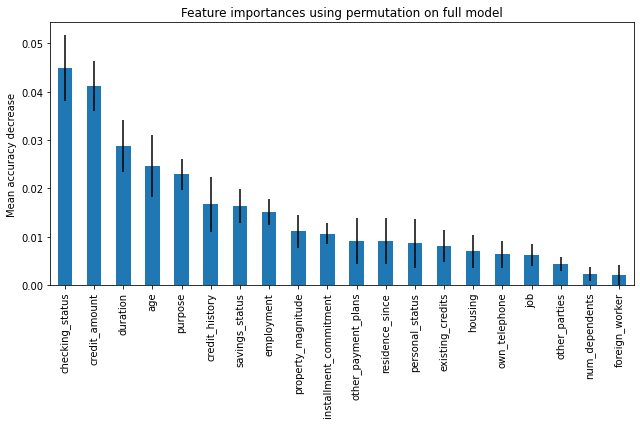

In [126]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(9, 6)
fig.tight_layout()
plt.show()

In [127]:
temp = X_train.copy()
temp['default'] = y_train
temp.groupby('foreign_worker').agg({'default': np.mean})

,default
foreign_worker,
yes,0.691710
no,0.892857


In [128]:
fig = px.box(
    data_frame=temp,
    y='age',
    x='default',
#    size=size_variable,
#    color=color_variable,
#    trendline='lowess',
#     labels={
#         score_variable: f"Average Cross Validation Score ({parser.primary_score_name})",
#     },
#     title=f"<b>{x_variable}</b> - Performance<br>" \
#           f"<sup>Size of point corresponds to '{size_variable}'</sup>",
#     custom_data=['labels'],
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO
)
fig.show()

NOTE: foreign worker seems like it should be important but is ranked last in feature importance.